<a href="https://colab.research.google.com/github/rukaiyafahmida/SoftComputing/blob/main/Assignment_02_170204004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import pandas as pd
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/4.2 Rukaiya/Dataset.csv')
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


#Preprossesing

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

seed = 4
torch.manual_seed(seed)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
def cleaner(text):
    text = text.lower()
    text=text[1:] 
    text = re.sub(urlPattern,'',text)
    text = text.translate(str.maketrans("","",string.punctuation))
    tokens = word_tokenize(text)
    final_tokens = [w for w in tokens if w not in stop_words]
    wordLemm = WordNetLemmatizer()
    final_words=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        final_words.append(word)
    return ' '.join(final_words)   

In [ ]:
df['final_text'] = df['Text'].apply(lambda x: cleaner(x))

In [ ]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [ ]:
df = df.sample(frac = 1) 
df

,Text,Sentiment,final_text
2894,Watching GS closely on today's trend-line. Has...,0,atching g closely today trendline leading spy
4163,AAP WEHAAAAAAAAAAA,1,ap wehaaaaaaaaaaa
405,WT had a huge 39 seller today... check out the...,1,huge 39 seller today check daily hold 4042 loo...
4355,AAP now 400% (glass ceiling 434.5) rejecting...,0,ap 400 glass ceiling 4345 rejecting 434 4325
4254,"FCX Puts, will go down in history as one of th...",0,cx put go history one dumbest acquisition time...
...,...,...,...
3578,does everybody know that AAP & TC can do VEY ...,1,oes everybody know aap tc vey little regard st...
4203,watch for move on F M KO MO GD TJX BCD,1,atch move ko mo gd tjx bcd
1881,PNA trying to break the DT line again and alre...,1,na trying break dt line already average daily ...
4565,"HCA continued relative strength today, moving ...",1,ca continued relative strength today moving fr...


In [ ]:
from sklearn.model_selection import train_test_split
x = df['final_text'].values
y = df['Sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [ ]:
df.head()

,Text,Sentiment,final_text
2894,Watching GS closely on today's trend-line. Has...,0,atching g closely today trendline leading spy
4163,AAP WEHAAAAAAAAAAA,1,ap wehaaaaaaaaaaa
405,WT had a huge 39 seller today... check out the...,1,huge 39 seller today check daily hold 4042 loo...
4355,AAP now 400% (glass ceiling 434.5) rejecting...,0,ap 400 glass ceiling 4345 rejecting 434 4325
4254,"FCX Puts, will go down in history as one of th...",0,cx put go history one dumbest acquisition time...


# One hot embedding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
 from keras.preprocessing.text import Tokenizer
 tokenizer = Tokenizer()
 tokenizer.fit_on_texts(x_train)
 X_train = tokenizer.texts_to_sequences(x_train)
 X_test = tokenizer.texts_to_sequences(x_test)
 vocab_size = len(tokenizer.word_index)+1

In [ ]:
 print(x_train[1])
 print(X_train[1]) 

dded app
[588, 473]


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
 from keras.preprocessing.sequence import pad_sequences
 maxlen = 1000
 X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
 X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras import layers 
import tensorflow as tf

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 200)         1865400   
                                                                 
 conv1d_8 (Conv1D)           (None, 999, 256)          102656    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 499, 256)         0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 497, 128)          98432     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 245, 64)          

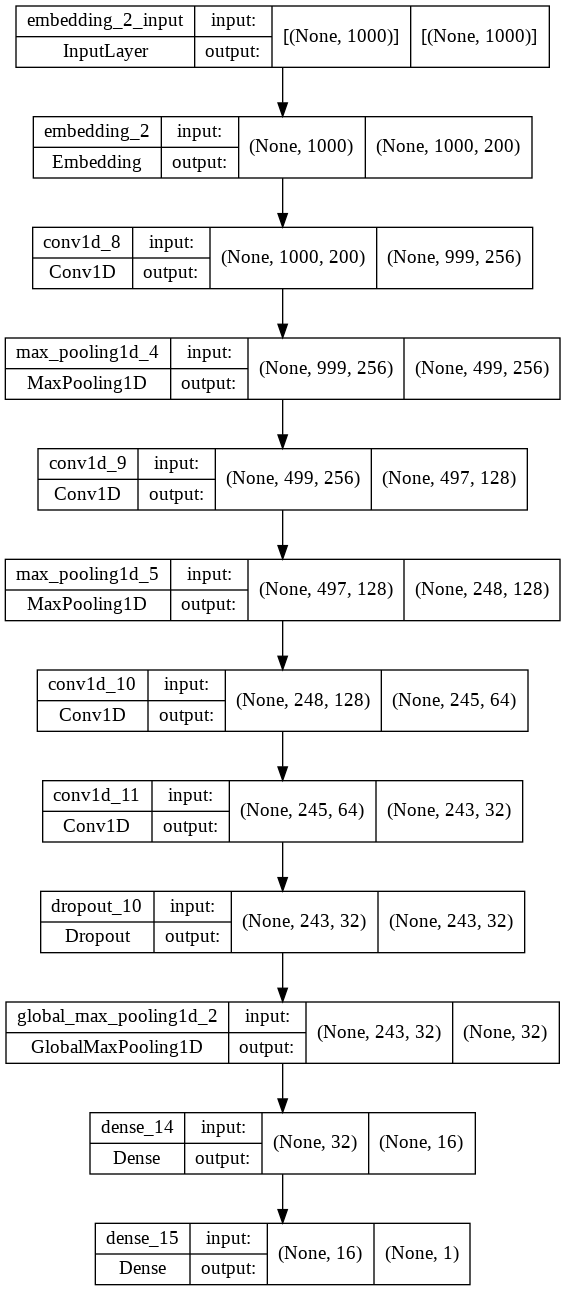

In [ ]:
seed = 4
torch.manual_seed(seed)
embedding_dim = 200
cnnmodel = Sequential()
cnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
cnnmodel.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
cnnmodel.add(layers.MaxPooling1D(pool_size = 2))
cnnmodel.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
cnnmodel.add(layers.MaxPooling1D(pool_size = 2))
cnnmodel.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
cnnmodel.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cnnmodel.add(layers.Dropout(0.2))
cnnmodel.add(layers.GlobalMaxPooling1D())
cnnmodel.add(layers.Dense(16, activation='relu'))
cnnmodel.add(layers.Dense(1, activation='sigmoid'))
cnnmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
cnnmodel.summary() 

tf.keras.utils.plot_model(cnnmodel, show_shapes = True, show_layer_names = True)


In [ ]:
history = cnnmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = cnnmodel.evaluate(X_train, y_train)
print("Training Accuracy: {:}".format(accuracy))

loss, oheaccuracy, f1_score, precision, recall = cnnmodel.evaluate(X_test, y_test)
print("Testing Accuracy:  {:}".format(oheaccuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 9s 53ms/step - loss: 0.6213 - accuracy: 0.6572 - f1_m: 0.7762 - precision_m: 0.6708 - recall_m: 0.9490 - val_loss: 0.5553 - val_accuracy: 0.7084 - val_f1_m: 0.7876 - val_precision_m: 0.7402 - val_recall_m: 0.8490
Epoch 2/10
145/145 [==============================] - 7s 49ms/step - loss: 0.3708 - accuracy: 0.8439 - f1_m: 0.8748 - precision_m: 0.8809 - recall_m: 0.8770 - val_loss: 0.5098 - val_accuracy: 0.7394 - val_f1_m: 0.7778 - val_precision_m: 0.8417 - val_recall_m: 0.7316
Epoch 3/10
145/145 [==============================] - 7s 49ms/step - loss: 0.1446 - accuracy: 0.9439 - f1_m: 0.9544 - precision_m: 0.9596 - recall_m: 0.9521 - val_loss: 0.6820 - val_accuracy: 0.7429 - val_f1_m: 0.7903 - val_precision_m: 0.8140 - val_recall_m: 0.7766
Epoch 4/10
145/145 [==============================] - 7s 49ms/step - loss: 0.0496 - accuracy: 0.9829 - f1_m: 0.9863 - precision_m: 0.9887 - recall_m: 0.9848 - val_loss: 0.9852 - val_accuracy: 0.7351 

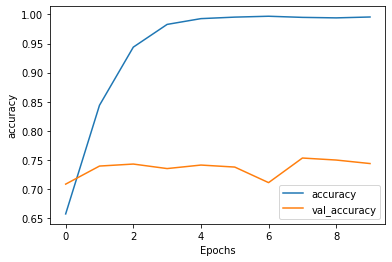

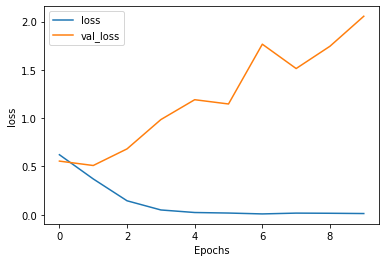

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Bag Of Words

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)


from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vectorizer.fit(x)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
print('Total training data: ', X_train.shape[0])
print('Total testing data:  ', X_test.shape[0])

Total training data:  4632
Total testing data:   1159


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 256)               2706944   
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                16448     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 16)               

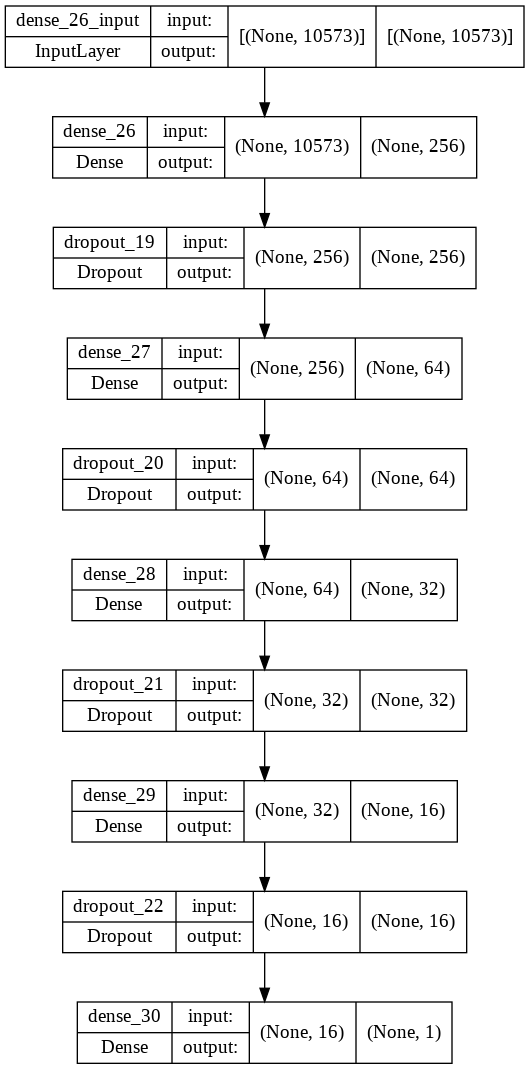

In [ ]:
bogmodel = Sequential()
bogmodel.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=64, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=32, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=16, activation='relu'))
bogmodel.add(Dropout(0.2))
bogmodel.add(Dense(units=1, activation='sigmoid'))

bogmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
bogmodel.summary() 

tf.keras.utils.plot_model(bogmodel, show_shapes = True, show_layer_names = True)


In [ ]:
history = bogmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = bogmodel.evaluate(X_train, y_train)
print("Training Accuracy: {}".format(accuracy))

loss, bogaccuracy, f1_score, precision, recall = bogmodel.evaluate(X_test, y_test)
print("Testing Accuracy: {}".format(bogaccuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 3s 12ms/step - loss: 0.5917 - accuracy: 0.6826 - f1_m: 0.7845 - precision_m: 0.6928 - recall_m: 0.9294 - val_loss: 0.4869 - val_accuracy: 0.7731 - val_f1_m: 0.8306 - val_precision_m: 0.7751 - val_recall_m: 0.9079
Epoch 2/10
145/145 [==============================] - 1s 9ms/step - loss: 0.3112 - accuracy: 0.8802 - f1_m: 0.9039 - precision_m: 0.8979 - recall_m: 0.9147 - val_loss: 0.4998 - val_accuracy: 0.7774 - val_f1_m: 0.8205 - val_precision_m: 0.8131 - val_recall_m: 0.8372
Epoch 3/10
145/145 [==============================] - 1s 9ms/step - loss: 0.1042 - accuracy: 0.9642 - f1_m: 0.9711 - precision_m: 0.9725 - recall_m: 0.9712 - val_loss: 0.8121 - val_accuracy: 0.7731 - val_f1_m: 0.8251 - val_precision_m: 0.7816 - val_recall_m: 0.8821
Epoch 4/10
145/145 [==============================] - 1s 9ms/step - loss: 0.0383 - accuracy: 0.9899 - f1_m: 0.9921 - precision_m: 0.9915 - recall_m: 0.9930 - val_loss: 1.0193 - val_accuracy: 0.7714 - v

In [ ]:

print("Testing Accuracy: {}".format(bogaccuracy))

Testing Accuracy: 0.7661777138710022


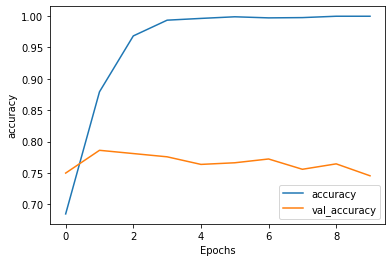

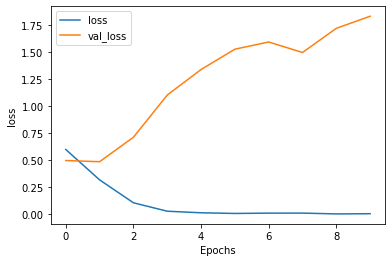

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# TF-IDF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)


from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer( ngram_range=(1,3), analyzer='char')

vectorizer.fit(x)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               2706944   
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 16)               

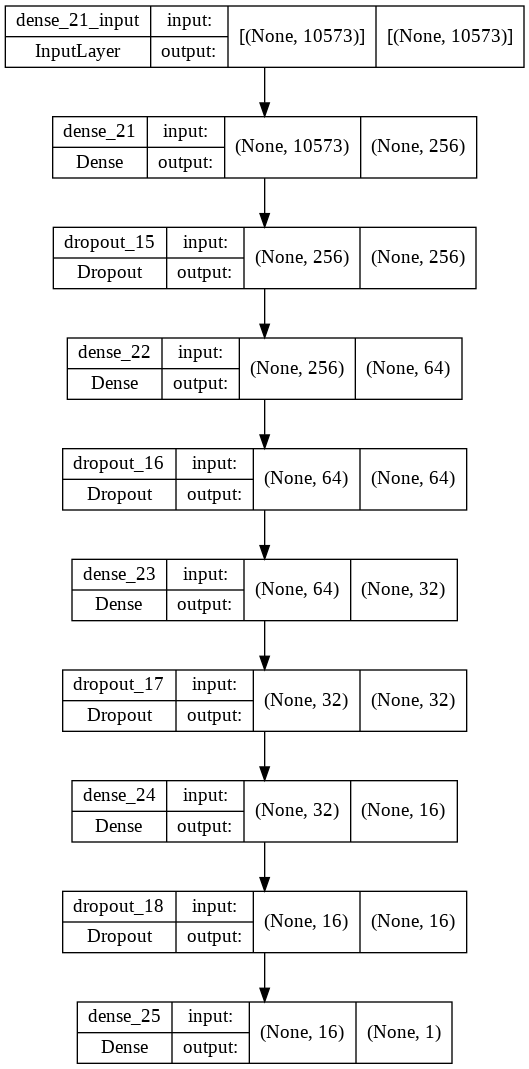

In [ ]:
tfmodel = Sequential()
tfmodel.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=64, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=32, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=16, activation='relu'))
tfmodel.add(Dropout(0.2))
tfmodel.add(Dense(units=1, activation='sigmoid'))

tfmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
tfmodel.summary() 

tf.keras.utils.plot_model(tfmodel, show_shapes = True, show_layer_names = True)


In [ ]:
history = tfmodel.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

loss, accuracy, f1_score, precision, recall = tfmodel.evaluate(X_train, y_train)
print("Training Accuracy: {}".format(accuracy))

loss, tfaccuracy, f1_score, precision, recall = tfmodel.evaluate(X_test, y_test)
print("Testing Accuracy:  {}".format(tfaccuracy))
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)



Epoch 1/10
145/145 [==============================] - 3s 13ms/step - loss: 0.6056 - accuracy: 0.6576 - f1_m: 0.7781 - precision_m: 0.6664 - recall_m: 0.9612 - val_loss: 0.5023 - val_accuracy: 0.7653 - val_f1_m: 0.8241 - val_precision_m: 0.7728 - val_recall_m: 0.8954
Epoch 2/10
145/145 [==============================] - 1s 10ms/step - loss: 0.3241 - accuracy: 0.8731 - f1_m: 0.8978 - precision_m: 0.8935 - recall_m: 0.9072 - val_loss: 0.5190 - val_accuracy: 0.7800 - val_f1_m: 0.8326 - val_precision_m: 0.7809 - val_recall_m: 0.9003
Epoch 3/10
145/145 [==============================] - 1s 10ms/step - loss: 0.0979 - accuracy: 0.9700 - f1_m: 0.9753 - precision_m: 0.9757 - recall_m: 0.9760 - val_loss: 0.7044 - val_accuracy: 0.7808 - val_f1_m: 0.8173 - val_precision_m: 0.8129 - val_recall_m: 0.8288
Epoch 4/10
145/145 [==============================] - 2s 16ms/step - loss: 0.0311 - accuracy: 0.9905 - f1_m: 0.9923 - precision_m: 0.9926 - recall_m: 0.9924 - val_loss: 1.1030 - val_accuracy: 0.7731 

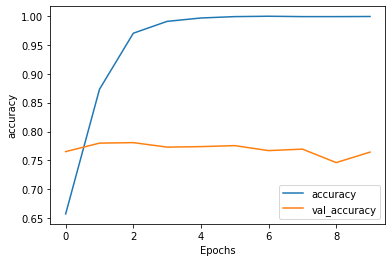

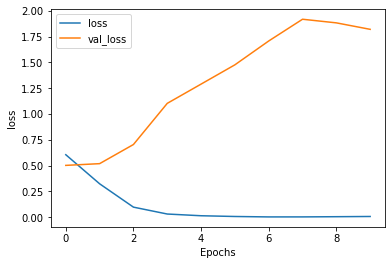

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

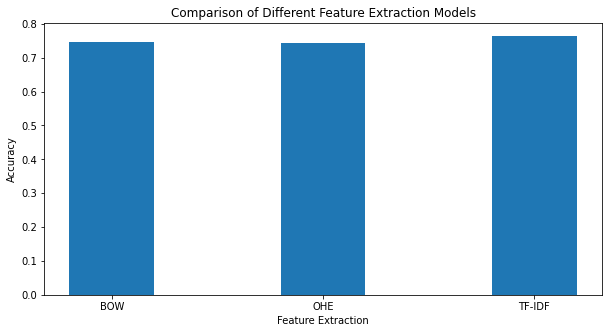

In [ ]:
data = {'BOW':bogaccuracy, 'OHE':oheaccuracy, 'TF-IDF':tfaccuracy}
tech = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(tech, values, width = 0.4)
 
plt.xlabel("Feature Extraction")
plt.ylabel("Accuracy")
plt.title("Comparison of Different Feature Extraction Models")
plt.show()